In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy
from scipy.stats import norm
import tensorflow_probability as tfp
import seaborn as sns
import pandas as pd
import corner 
import math as m
import copy

tfd=tfp.distributions

In [64]:
def draw(base, position = None, ax = None,R = 100):
    ## function to plot the geometry
    if ax == None:
        f,ax=plt.subplots()
        
    if position is not None:

        t = tf.convert_to_tensor(thickness,dtype = tf.float32)

        ps2 = position-t
        
        ps2 = tf.reverse(ps2,[-1])
        
        for i in tf.range(2,Number_para+2): ## lower layer
            base[i].assign([base[i][0],ps2[i-2]])

        for i in tf.range(Number_para+6,2*Number_para+6): ## upper layer
            base[i].assign([base[i][0],position[i-Number_para-6]])

    x = base[:,0]
    z = base[:,1]
    for i in range(base.shape[0]):
        ax.plot(x[i:i+2],z[i:i+2],'k-')
    x_ = np.linspace(-R,R,10)
    ax.plot(x_,np.zeros(np.shape(x_)),lw = 0.5)# draw a reference line, surface
    ax.plot([x[0],x[-1]],[z[0],z[-1]],'k-')
    ax.set_ylim(base[tf.argmin(base[:,1])][1].numpy()-10,5)
    ax.set_xlim(-R,R)
    
    
pi = tf.constant(m.pi) # define PI in Tensorflow form

In [65]:
def draw_MCMC(base,samples,Truth = None,ax = None,R = 70):
    
    if ax == None:
        f,ax=plt.subplots()
    
    if Truth is not None:
        draw(base,Truth,ax = ax, R = R)
            
    x1 = np.linspace(-R,R,Number_para)

    t = tf.convert_to_tensor(thickness,dtype = tf.float32)
    for ps in samples:
        ps2 = ps-t

        ps2 = tf.reverse(ps2,[-1])

        for i in tf.range(2,Number_para+2): ## lower layer
            base[i].assign([base[i][0],ps2[i-2]])

        for i in tf.range(Number_para+6,2*Number_para+6): ## upper layer
            base[i].assign([base[i][0],ps[i-Number_para-6]])

        for i in range(Number_para+5,base.shape[0]-2):
            ax.plot(base[:,0][i:i+2],base[:,1][i:i+2],'r-',alpha = 0.01)
    
    ax.plot(x1,np.zeros(np.shape(x1)),lw = 0.5)# draw a reference line, surface

    ax.set_ylim(base[tf.argmin(base[:,1])][1].numpy()-10,5)
    ax.set_xlim(-R,R)

In [105]:
depth = -20
thickness = 20

corners=np.array([[-200,depth-thickness],
                  [-70,depth-thickness],
                  [70,depth-thickness],# bottom left coner
              [200,depth-thickness], 
              [200,depth], # bottom right coner
              [70, depth], # top right coner
              [-70,depth],# top left coner
              [-200,depth]])
Number_para = 20
obs_N = 8
points = np.empty((2*Number_para+8,2),dtype = np.float32)

points[0] = corners[0]
points[1] = corners[1]

for i in range(6):
    points[Number_para+i] = corners[i]
    
points[-2]=corners[-2]
points[-1]=corners[-1]

np.random.seed(21)

x2 = np.linspace(-70,70,Number_para+2)
x1 = np.linspace(70,-70,Number_para+2)

thickness = 20
y1 = np.random.uniform(-2,-50,Number_para)
y2 = y1-thickness

y1 = list(reversed(y1))

for i in range(2,Number_para+2): ## lower layer
    points[i][1] = y2[i-2]
    points[i][0] = x2[i-1]
    
for i in range(Number_para+6,2*Number_para+6): ## upper layer
    points[i][1] = y1[i-Number_para-6]
    points[i][0] = x1[i-Number_para-5]


(-70, 70)

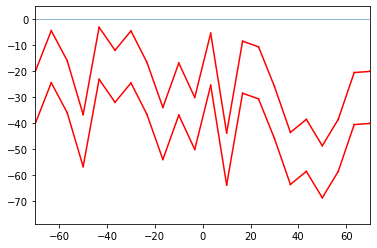

In [106]:
# Draw Base
f,ax=plt.subplots()
x = points[:,0]
z = points[:,1]
for i in range(points.shape[0]):
    ax.plot(x[i:i+2],z[i:i+2],'r-')
x_ = np.linspace(-70,70,10)
ax.plot(x_,np.zeros(np.shape(x_)),lw = 0.5)# draw a reference line, surface
ax.plot([x[0],x[-1]],[z[0],z[-1]],'r-')
ax.set_ylim(min(points[:,1])-10,5)
ax.set_xlim(-70,70)

#### Z direction gravity line integration following Won 1987
\begin{equation}
\Delta g_{z}=2 G \rho \sum_{i=1}^{n} Z_{i}
\end{equation}

\begin{equation}
Z=A\left[\left(\theta_{1}-\theta_{2}\right)+B \ln \frac{r_{2}}{r_{1}}\right]
\end{equation}

where,   
\begin{equation}
\begin{aligned}
&A=\frac{\left(x_{2}-x_{1}\right)\left(x_{1} z_{2}-x_{2} z_{1}\right)}{\left(x_{2}-x_{1}\right)^{2}+\left(z_{2}-z_{1}\right)^{2}}\\
&B=\frac{z_{2}-z_{1}}{x_{2}-x_{1}}
\end{aligned}
\end{equation}

and,   
\begin{equation}
\begin{aligned}
&r_{1}^{2}=x_{1}^{2}+z_{1}^{2}\\
&r_{2}^{2}=x_{2}^{2}+z_{2}^{2}
\end{aligned}
\end{equation}


In [107]:

def A(x,z,p1,p2):
    numerator = (x[p2]-x[p1])*(x[p1]*z[p2]-x[p2]*z[p1])
    denominator = (x[p2]-x[p1])**2 + (z[p2]-z[p1])**2
    return (numerator/denominator)


def B(x,z,p1,p2):
    '''
    x : array, x coordinate
    z : array, z coordinate
    p1, p2 : int, position
    
    '''
    return ((z[p1]-z[p2])/(x[p2]-x[p1]))


def theta(x,z, p):
    if tf.math.not_equal(x[p], 0) :
        if tf.less(tf.atan(tf.divide(z[p],x[p])),0):
            return(tf.atan(tf.divide(z[p],x[p]))+pi)
        else:
            return(tf.atan(tf.divide(z[p],x[p])))
    elif tf.math.logical_and(tf.math.equal(x[p], 0), tf.math.not_equal(z[p], 0)):
        return(pi/2)
    else: return(0.)


def r(x,z,p):
    '''
    x : array, x coordinate
    z : array, z coordinate
    p : int, position
    
    '''
    return(tf.sqrt(x[p]**2+z[p]**2))


def Z(x,z,p1,p2):
    
    if tf.logical_or(tf.logical_and(tf.equal(x[p1],z[p1]),tf.equal(x[p1],0.)), tf.logical_and(tf.equal(x[p2],z[p2]),tf.equal(x[p2],0.))):
        return(0.)

    elif tf.equal(x[p1], x[p2]):
        return((x[p1]*tf.math.log(r(x,z,p2)/r(x,z,p1))))
    
    else:
    
        theta1 = theta(x,z, p1)
        theta2 = theta(x,z, p2)

        r1 = r(x,z,p1)
        r2 = r(x,z,p2)

        _A = A(x,z,p1,p2)
        _B = B(x,z,p1,p2)

        Z_result = _A*((theta1-theta2)+_B*tf.math.log(r1/r2))
        return(Z_result)


def g(x,z,loc):

    G = tf.constant(6.67 * 10**(-11)) # gravitational constant  m^3 kg ^-1 s^-2
    rho = tf.constant(1000.)        # density difference   kg/m^3

    _x = x-loc[0]
    _z = z-loc[1]

    Z_sum = tf.constant(0.)

    for i in tf.range(_x.shape[0]-1):
        Z_sum = tf.add(Z_sum, Z(_x,_z,i,i+1))

    Z_sum = tf.add(Z_sum, Z(_x,_z,-1,0))

    g = 2*G*rho * Z_sum

    return(g)


def grav(x,z,ps):
    """
    points: base point, fixing the x position
    ps: Positions,Variable(N elements vector), tuning z position
    
    """
    thick = tf.convert_to_tensor(thickness,dtype = tf.float32)
    N1 = tf.constant(Number_para)
    ps2 = ps-thick

    ps2 = tf.reverse(ps2,[-1])

    for i in tf.range(2,N1+2): ## lower layer
        z[i].assign(ps2[i-2])

    for i in tf.range(N1+6,2*N1+6): ## upper layer
        z[i].assign(ps[i-N1-6])

    x_obv = tf.linspace(-70., 70., obs_N+2)
    y_obv = tf.zeros(tf.shape(x_obv))
    obv = tf.stack((x_obv,y_obv),axis = 1)


    gravity = tf.TensorArray(tf.float32, size=obv.shape[0]-2)

    j = tf.constant(0)
    for i in obv[1:-1]:
        gravity=gravity.write(j,-g(x,z,i))
        j = tf.add(j,1)
    return gravity.stack()



def joint_log_prob(D,x,z,ps):
    """
    D: is the observation data
    ps: Positions,Variable(N elements vector)
    """
    # define random variables prior
    
    mvn_prior = tfd.MultivariateNormalTriL(
            loc = mu_prior,
            scale_tril=tf.linalg.cholesky(cov_prior))
    # define likelihood
    
    Gm_ = grav(x,z,ps)
    
    mvn_likelihood = tfd.MultivariateNormalFullCovariance(
            loc = Gm_,
            covariance_matrix= cov)
    
    # return the posterior probability
    return(mvn_prior.log_prob(z[Number_para+6:2*Number_para+6])
          +mvn_likelihood.log_prob(D))


Define the Prior and likelihood distribution

In [108]:
# prior
mu_prior = -20.*tf.ones([Number_para],dtype = tf.float32)
cov_prior = 20.*tf.eye(Number_para)

# likelihood
sig_e = 0.0000001
cov = sig_e**2*tf.eye(obs_N)

In [109]:
points = tf.Variable(points,dtype = tf.float32)

In [110]:
# define the ground truth
tf.random.set_seed(1234)
tf.random.uniform([Number_para])
True_position = tf.random.uniform([Number_para],-30,-1,seed = 10)
x = tf.Variable(points[:,0])
z = tf.Variable(points[:,1])
obs_data = grav(x,z,True_position)

In [111]:
D = obs_data

In [112]:
D

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([7.8100556e-06, 8.7888793e-06, 9.0200983e-06, 8.3544155e-06,
       7.7874865e-06, 7.1375398e-06, 7.5782809e-06, 7.9452821e-06],
      dtype=float32)>

#### create some noise

In [113]:
tf.random.set_seed(1234)
noise = tf.random.normal([obs_N],mean =0,stddev =sig_e,seed = 1)

In [114]:
D_noise = D+noise

In [115]:
joint_log_prob(D,x,z,True_position)

<tf.Tensor: shape=(), dtype=float32, numpy=15.354324>

In [116]:
def grav_calculate(_x,_z,x_obs=None, R=70,ax = None,style = None,**args):
    if ax is None:
        f,ax=plt.subplots()
    if x_obs is None:
        x_obs = np.linspace(-R,R,501)
    y = np.zeros(np.shape(x_obs))
    obv = np.vstack((x_obs,y)).T
    gravity = []
    for i in obv:
        gravity.append(-g(_x,_z,i))
    gravity = np.array(gravity)
    if style is None:
        style = '-'
    ax.set_title('gravity response at surface')
    ax.set_ylabel('g_z ($m/s^2$ )')
    ax.set_ylim(4e-6,10e-6)
    ax.set_xlim(-70,70)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    ax.plot(x_obs,gravity,style,**args)
    return gravity

In [117]:
D_noise

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([7.777690e-06, 8.974654e-06, 9.059655e-06, 8.377532e-06,
       7.811731e-06, 6.942682e-06, 7.565298e-06, 8.216657e-06],
      dtype=float32)>

In [118]:
points

<tf.Variable 'Variable:0' shape=(48, 2) dtype=float32, numpy=
array([[-200.       ,  -40.       ],
       [ -70.       ,  -40.       ],
       [ -63.333332 ,  -24.338795 ],
       [ -56.666668 ,  -35.877262 ],
       [ -50.       ,  -56.606384 ],
       [ -43.333332 ,  -23.03758  ],
       [ -36.666668 ,  -31.884293 ],
       [ -30.       ,  -24.437117 ],
       [ -23.333334 ,  -36.509052 ],
       [ -16.666666 ,  -53.867695 ],
       [ -10.       ,  -36.78949  ],
       [  -3.3333333,  -50.012383 ],
       [   3.3333333,  -25.339405 ],
       [  10.       ,  -63.635414 ],
       [  16.666666 ,  -28.395544 ],
       [  23.333334 ,  -30.549984 ],
       [  30.       ,  -45.80462  ],
       [  36.666668 ,  -63.457584 ],
       [  43.333332 ,  -58.429302 ],
       [  50.       ,  -68.58328  ],
       [  56.666668 ,  -58.44652  ],
       [  63.333332 ,  -40.444    ],
       [  70.       ,  -40.       ],
       [ 200.       ,  -40.       ],
       [ 200.       ,  -20.       ],
       [  70.

In [119]:
True_position

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([ -5.1785946, -20.606672 , -11.302174 ,  -5.881212 , -25.273802 ,
       -25.910046 , -22.322052 , -21.430578 , -10.866999 ,  -8.264807 ,
       -20.506378 ,  -2.7172203, -15.685033 ,  -4.4548607,  -1.9767189,
       -15.243669 ,  -1.4924355,  -5.306797 , -27.638058 , -17.484085 ],
      dtype=float32)>

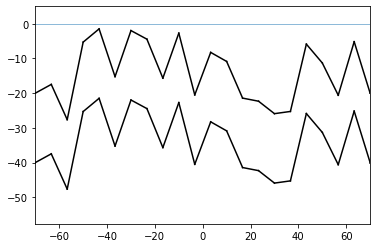

In [120]:
draw(points,True_position,R = 70)

array([7.0898241e-06, 7.0926530e-06, 7.0956539e-06, 7.0988312e-06,
       7.1021768e-06, 7.1057075e-06, 7.1094369e-06, 7.1133650e-06,
       7.1175086e-06, 7.1218724e-06, 7.1264676e-06, 7.1313029e-06,
       7.1363888e-06, 7.1417371e-06, 7.1473510e-06, 7.1532531e-06,
       7.1594482e-06, 7.1659579e-06, 7.1727850e-06, 7.1799409e-06,
       7.1874460e-06, 7.1953073e-06, 7.2035468e-06, 7.2121743e-06,
       7.2212160e-06, 7.2306721e-06, 7.2405610e-06, 7.2509051e-06,
       7.2616931e-06, 7.2729958e-06, 7.2847820e-06, 7.2970897e-06,
       7.3099345e-06, 7.3233432e-06, 7.3373167e-06, 7.3518713e-06,
       7.3670521e-06, 7.3828569e-06, 7.3993156e-06, 7.4164313e-06,
       7.4342397e-06, 7.4527538e-06, 7.4719978e-06, 7.4919849e-06,
       7.5127368e-06, 7.5342650e-06, 7.5566018e-06, 7.5797529e-06,
       7.6037386e-06, 7.6285814e-06, 7.6542974e-06, 7.6808892e-06,
       7.7083678e-06, 7.7367786e-06, 7.7660889e-06, 7.7963186e-06,
       7.8274752e-06, 7.8595676e-06, 7.8925777e-06, 7.9265110e

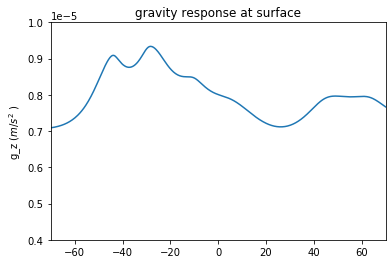

In [121]:
grav_calculate(x,z,x_obs = tf.linspace(-70., 70.,500),R = 70)

In [122]:
True_position

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([ -5.1785946, -20.606672 , -11.302174 ,  -5.881212 , -25.273802 ,
       -25.910046 , -22.322052 , -21.430578 , -10.866999 ,  -8.264807 ,
       -20.506378 ,  -2.7172203, -15.685033 ,  -4.4548607,  -1.9767189,
       -15.243669 ,  -1.4924355,  -5.306797 , -27.638058 , -17.484085 ],
      dtype=float32)>

#### Gradient decent

In [123]:
mu = tf.random.uniform([Number_para],minval = -20,maxval = -2,seed = 1) # initial parameters

In [124]:
mu

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-16.95835  ,  -2.494133 ,  -3.7934685, -17.015095 , -17.381754 ,
       -11.354611 , -19.550795 ,  -2.1369534, -19.489628 , -18.08309  ,
       -11.849029 ,  -4.2931557,  -7.620432 , -15.534253 ,  -2.7404747,
       -15.672891 ,  -8.173765 , -16.082691 ,  -4.708123 , -16.539717 ],
      dtype=float32)>

In [125]:
with tf.GradientTape() as t:  
    t.watch(x)
    loss = joint_log_prob(D_noise,x,z,mu) # negative log posterior
dlossdmu = t.gradient(loss,x)
    

In [126]:
print(dlossdmu)

tf.Tensor(
[ 1.3574000e+01  7.6572791e-02  4.9998987e-01 -1.8129483e-01
 -8.4358275e-02 -8.3550394e-02  8.6795628e-01  1.0920365e-01
 -8.4148121e-01  9.1939771e-01  1.3841173e-01  5.6429946e-01
  6.6754389e-01 -2.8756633e+00  6.0708368e-01  2.1322219e+00
 -4.5891458e-01  1.4962149e+00 -3.8619380e+00 -4.6126862e+00
  3.6213236e+00  4.0932961e+00  5.6598198e-01 -1.4003656e+01
  1.3574001e+01 -7.2839308e-01 -6.7711430e+00 -7.2934361e+00
  8.4656830e+00  6.3556652e+00 -2.5732107e+00  1.1757703e+00
 -4.7702951e+00 -3.4581890e+00  4.4610538e+00 -7.4482918e-01
 -5.9806097e-01 -4.9196833e-01 -3.0810595e+00  2.8747721e+00
  1.2891984e-01 -2.8378124e+00  1.0448316e+00 -1.3065413e+00
  1.1816800e-02  7.8002894e-01  1.6873986e-02 -1.3519277e+01], shape=(48,), dtype=float32)


In [127]:
for i in range(10):
    with tf.GradientTape() as t:  
        t.watch(z)
        loss = tf.negative(joint_log_prob(D_noise,x,z,mu)) # negative log posterior
        dlossdmu = t.gradient(loss,z)
    mu = mu-0.01*dlossdmu[Number_para+6:2*Number_para+6]
    print('Iteration',i)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9


In [128]:
True_position

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([ -5.1785946, -20.606672 , -11.302174 ,  -5.881212 , -25.273802 ,
       -25.910046 , -22.322052 , -21.430578 , -10.866999 ,  -8.264807 ,
       -20.506378 ,  -2.7172203, -15.685033 ,  -4.4548607,  -1.9767189,
       -15.243669 ,  -1.4924355,  -5.306797 , -27.638058 , -17.484085 ],
      dtype=float32)>

In [129]:
MAP

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-16.95835  ,  -2.494133 ,  -3.7934685, -17.015095 , -17.381754 ,
       -11.354611 , -19.550795 ,  -2.1369534, -19.489628 , -18.08309  ,
       -11.849029 ,  -4.2931557,  -7.620432 , -15.534253 ,  -2.7404747,
       -15.672891 ,  -8.173765 , -16.082691 ,  -4.708123 , -16.539717 ],
      dtype=float32)>

In [130]:
MAP = mu
MAP

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-17.35906  ,  -3.6524408,  -4.7564692, -17.556402 , -17.92684  ,
       -12.013368 , -20.136013 ,  -2.76296  , -19.774555 , -18.23842  ,
       -11.949288 ,  -4.3704295,  -7.377816 , -15.079431 ,  -2.2329943,
       -15.176665 ,  -7.820381 , -16.018671 ,  -4.9983654, -16.60744  ],
      dtype=float32)>

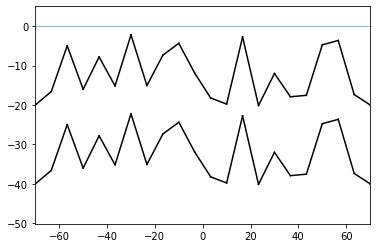

In [131]:
draw(points,MAP,R = 70)

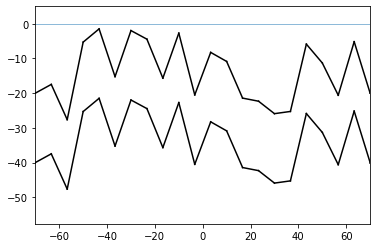

In [132]:
draw(points,True_position,R=70)

### Random Walk MCMC

In [133]:
num_results = 10
burnin = 0

initial_chain_state = [
    -10 * tf.ones([Number_para], dtype=tf.float32, name="init_t1"),
]

unnormalized_posterior_log_prob = lambda *args: joint_log_prob(D,x,z,*args)

def gauss_new_state_fn(scale, dtype):
  gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
  def _fn(state_parts, seed):
    next_state_parts = []
    seed_stream  = tfp.util.SeedStream(seed, salt='RandomNormal')
    for sp in state_parts:
      next_state_parts.append(sp + gauss.sample(
        sample_shape=sp.shape, seed=seed_stream()))
    return next_state_parts
  return _fn

dtype = np.float32

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        new_state_fn=gauss_new_state_fn(scale=1, dtype=dtype)),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

/Users/zhouji/anaconda3/envs/bys/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [134]:
accept_index = np.where(accepted==True)
accepted_samples = samples[accept_index]

In [28]:
accepted_samples.shape[0]/num_results

0.5

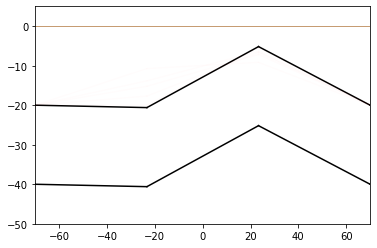

In [29]:
draw_MCMC(points,accepted_samples[:,:,0],Truth=True_position) # [:,:,0] transpost the results for plotting

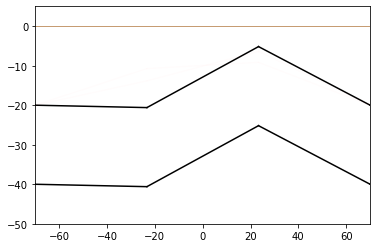

In [30]:
draw_MCMC(points,accepted_samples[0:2,:,0],Truth=True_position)

In [31]:
points

<tf.Variable 'Variable:0' shape=(12, 2) dtype=float32, numpy=
array([[-200.       ,  -40.       ],
       [ -70.       ,  -40.       ],
       [ -23.333334 ,  -33.841675 ],
       [  23.333334 ,  -26.392065 ],
       [  70.       ,  -40.       ],
       [ 200.       ,  -40.       ],
       [ 200.       ,  -20.       ],
       [  70.       ,  -20.       ],
       [  23.333334 ,   -6.3920655],
       [ -23.333334 ,  -13.841675 ],
       [ -70.       ,  -20.       ],
       [-200.       ,  -20.       ]], dtype=float32)>

In [32]:
True_position

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ -5.1785946, -20.606672 ], dtype=float32)>

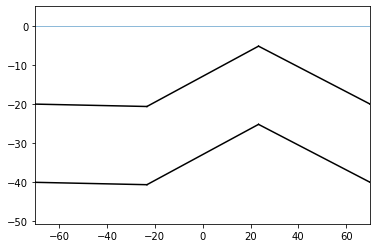

In [33]:
draw(points,True_position,R=70)

# Hessian Method

In [89]:
joint_log_prob(D,x,z,MAP)

<tf.Tensor: shape=(), dtype=float32, numpy=-73.736305>

In [93]:
with tf.GradientTape() as t:
    with tf.GradientTape() as tt:
        tt.watch(z)
        loss = tf.negative(joint_log_prob(D,x,z,MAP))
    jac = tt.gradient(loss,z,unconnected_gradients='zero')
hess = t.jacobian(jac,z,unconnected_gradients = 'none')
print(hess)

tf.Tensor(
[[ 0.08976986  0.2197499   0.05135277 ... -0.0389077  -0.14892656
  -0.05482849]
 [ 0.21974984  0.5174447   0.12156007 ... -0.09293704 -0.34956864
  -0.12668237]
 [ 0.05135274  0.1215601   0.03200173 ... -0.0221228  -0.08163413
  -0.02906491]
 ...
 [-0.0389077  -0.0929371  -0.0221228  ...  0.08053702  0.06576653
   0.02215236]
 [-0.14892656 -0.34956864 -0.08163416 ...  0.06576658  0.2804089
   0.09511851]
 [-0.05482849 -0.12668237 -0.02906491 ...  0.02215235  0.09511853
   0.04225738]], shape=(48, 48), dtype=float32)


In [58]:
with tf.GradientTape(persistent=True,watch_accessed_variables=False) as tt:
    tt.watch(z)
    loss = tf.negative(joint_log_prob(D,x,z,MAP))
    jac = tt.gradient(loss,z,unconnected_gradients='zero')
with t.stop_recording():
    hess = tt.jacobian(jac,z,unconnected_gradients = 'none')
print(hess)

tf.Tensor(
[[ 0.08976985  0.2197499   0.05135278 ... -0.03890769 -0.14892656
  -0.05482849]
 [ 0.21974984  0.5174447   0.12156007 ... -0.09293701 -0.34956867
  -0.12668237]
 [ 0.05135274  0.12156019  0.03200172 ... -0.02212279 -0.08163416
  -0.02906491]
 ...
 [-0.0389077  -0.0929371  -0.02212279 ...  0.08053707  0.06576666
   0.02215236]
 [-0.14892656 -0.34956864 -0.08163415 ...  0.06576656  0.2804088
   0.09511851]
 [-0.05482849 -0.12668237 -0.02906491 ...  0.02215237  0.09511853
   0.04225738]], shape=(48, 48), dtype=float32)


In [ ]:
print(hess)

In [59]:
HessMatrix = np.empty(shape = [Number_para,Number_para])
for x,i1 in enumerate(range(Number_para+6,2*Number_para+6)):
    for y,i2 in enumerate(range(Number_para+6,2*Number_para+6)):
        HessMatrix[x,y] = hess[i1,i2]

In [60]:
print(HessMatrix)

[[0.05872279 0.00623582 0.02576999 0.05594676 0.07026859 0.07606975
  0.05061729 0.02731137 0.03236937 0.03158258 0.02956313 0.01702958
  0.01250388 0.01399422 0.01450446 0.01415169 0.01032265 0.00724968
  0.00372577 0.00438201]
 [0.00623583 0.01955487 0.00317126 0.03631965 0.04554231 0.04919994
  0.03199875 0.01654427 0.01851492 0.01701385 0.01461162 0.00808847
  0.00606555 0.00670896 0.00626126 0.00632894 0.00462308 0.00341967
  0.00179283 0.00221016]
 [0.02576999 0.00317147 0.03579789 0.083551   0.10710803 0.11555287
  0.07402032 0.0371366  0.03977187 0.03472524 0.0273969  0.0145126
  0.01117872 0.01224692 0.01009541 0.0106862  0.00782199 0.00614921
  0.00329491 0.00426121]
 [0.05594673 0.03631965 0.08355089 0.27284175 0.24722904 0.25022933
  0.16219844 0.08335704 0.09240484 0.08404108 0.07109711 0.0389635
  0.02890752 0.03126755 0.02712716 0.02799367 0.02043355 0.01556941
  0.0082452  0.01040313]
 [0.07026857 0.04554234 0.10710795 0.24722904 0.42171919 0.3402794
  0.20460901 0.1062

In [ ]:
def Laplace_appro(H,C_prior):
    return tf.linalg.inv((tf.add(H,tf.linalg.inv(C_prior))))


In [ ]:
cov_post = Laplace_appro(HessMatrix,cov_prior)

In [100]:
cov_post

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 2.2091596, -1.6563011,  0.5120193],
       [-1.656301 ,  4.037153 , -1.9677684],
       [ 0.5120189, -1.9677678,  2.8830686]], dtype=float32)>

In [101]:
@tf.function
def matrixcompute(matrix1,matrix2,Cov):
    matrix1 = tf.cast(matrix1,tf.float32)
    matrix2 = tf.cast(matrix2,tf.float32)
    matrix = tf.subtract(matrix1, matrix2)
    matrix = tf.reshape(matrix,[matrix.shape[0],1])
    matrix_T = tf.transpose(matrix)
    Cov_inv = tf.linalg.inv(Cov)
    result = tf.multiply(tf.constant(1/2),tf.matmul(tf.matmul(matrix_T,Cov_inv),matrix))
    return result

def acceptance_gpCN(m_current , m_proposed):
    delta_current = tf.subtract(negative_log_post(m_current),matrixcompute(m_current,MAP,cov_post))
    delta_proposed = tf.subtract(negative_log_post(m_proposed),matrixcompute(m_proposed,MAP,cov_post))

    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(0., 1.),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    if(accept_ratio > sample):
        return True
    else:
        return False
        
from IPython.display import clear_output
# define leaning rate
beta = 0.4

@tf.function
def draw_proposal(m_current):
    
    _term1 = MAP
    
    ## sqrt term
    tem_1 = tf.convert_to_tensor(tf.sqrt(1-beta**2),dtype = tf.float32)
    ## sqrt(1-beta^2)()
    _term2 = tf.multiply(tem_1,(tf.subtract(m_current,MAP)))
    
    Xi = tfd.MultivariateNormalFullCovariance(
            loc = 0,
            covariance_matrix= cov_post)

    Xi_s = tfd.Sample(Xi)
    _term3 = tf.multiply(beta,Xi_s.sample())
    
    m_proposed = tf.add(MAP,tf.add(_term2,_term3))
    
    return m_proposed       

In [102]:
draw_proposal(MAP)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ -6.25108 , -18.79881 , -11.842674], dtype=float32)>

In [ ]:
def negative_log_post(mu):
    return(tf.negative(joint_log_prob(D,points,mu)))

In [53]:
mu_init = -10 * tf.ones([Number_para], dtype=tf.float32)

number_of_steps = 2000
def run_chain():
    burn_in = 1000
    steps = number_of_steps
    k = 0
    accepted = []
    rejected = []

    m_current = mu_init  # init m
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal(m_current)

        
        if acceptance_gpCN(m_current,m_proposed):
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed.numpy())
        else:
            m_current = m_current
            rejected.append(m_proposed.numpy())
    
    return accepted,rejected
#     print("acceptance rate = %0.1f%%", 100*np.shape(accepted)[0]/steps)
    
accepted,rejected = run_chain()
np.shape(accepted)[0]
print('Acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))

accepted = np.array(accepted)



NameError: name 'draw_proposal' is not defined

gpCN seems not quite correct, the reason is demonstrated below in DEBUG:

-  the main reason it's failed is the acceptence rate: negative log post minus the diff in $m_v$ makes the good proposal have big $\Delta$

let's try pCN first

In [105]:
cov_post

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 2.2091596, -1.6563011,  0.5120193],
       [-1.656301 ,  4.037153 , -1.9677684],
       [ 0.5120189, -1.9677678,  2.8830686]], dtype=float32)>

In [58]:
cov_prior

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[20.,  0.,  0.],
       [ 0., 20.,  0.],
       [ 0.,  0., 20.]], dtype=float32)>

### try pCN MCMC

first define a likelihood function rather than posteior function

In [ ]:
def likelihood(D,points_copy,ps):

    Gm_ = grav(points_copy,ps)
    
    mvn_likelihood = tfd.MultivariateNormalFullCovariance(
            loc = Gm_,
            covariance_matrix= cov)
    
    return mvn_likelihood.log_prob(D)

def negative_likeli(D,points,ps):
    return tf.negative(likelihood(D,points,ps))

In [164]:
negative_likeli(D,points,m_test)

<tf.Tensor: shape=(), dtype=float32, numpy=-113.3639>

In [165]:
def acceptance_pCN(m_current , m_proposed):
    delta_current = negative_likeli(D,points,m_current)
    delta_proposed = negative_likeli(D,points,m_proposed)
    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(0., 1.),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    if(accept_ratio > sample):
        return True
    else:
        return False

In [ ]:
mu_init = -10 * tf.ones([Number_para], dtype=tf.float32)

number_of_steps = 2000
def run_chain():
    burn_in = 1000
    steps = number_of_steps
    k = 0
    accepted = []
    rejected = []

    m_current = mu_init  # init m
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal(m_current)

        if acceptance_pCN(m_current,m_proposed):
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed.numpy())
        else:
            m_current = m_current
            rejected.append(m_proposed.numpy())
    
    return accepted,rejected
#     print("acceptance rate = %0.1f%%", 100*np.shape(accepted)[0]/steps)
    
accepted,rejected = run_chain()
np.shape(accepted)[0]
print('Acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))

accepted = np.array(accepted)

In [283]:
grav(points,True_position)

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([7.5347557e-06, 7.6035763e-06, 7.6436881e-06, 7.6689848e-06,
       7.6755787e-06, 7.6385968e-06, 7.5650173e-06, 7.4872437e-06,
       7.4231516e-06, 7.3707970e-06, 7.3245947e-06, 7.2892985e-06,
       7.2740945e-06, 7.2839098e-06, 7.3184824e-06, 7.3736924e-06,
       7.4428372e-06, 7.5176386e-06, 7.5902572e-06, 7.6503502e-06,
       7.6906690e-06, 7.7293871e-06, 7.7813011e-06, 7.8486546e-06,
       7.9329047e-06, 8.0366217e-06, 8.1579738e-06, 8.2825200e-06,
       8.3943714e-06, 8.4804597e-06, 8.4792273e-06, 8.5413640e-06,
       8.7112030e-06, 8.8684801e-06, 8.8680708e-06, 8.8990046e-06,
       8.7795552e-06, 8.5777046e-06, 8.3934628e-06, 8.1993585e-06,
       8.0200407e-06, 7.8709263e-06, 7.7555715e-06, 7.6818305e-06,
       7.6535725e-06, 7.6616661e-06, 7.6807482e-06, 7.6832393e-06,
       7.6609967e-06, 7.6128995e-06], dtype=float32)>

In [285]:
grav_new(_x,_z,True_position)

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([7.5347557e-06, 7.6035763e-06, 7.6436881e-06, 7.6689848e-06,
       7.6755787e-06, 7.6385968e-06, 7.5650173e-06, 7.4872437e-06,
       7.4231516e-06, 7.3707970e-06, 7.3245947e-06, 7.2892985e-06,
       7.2740945e-06, 7.2839098e-06, 7.3184824e-06, 7.3736924e-06,
       7.4428372e-06, 7.5176386e-06, 7.5902572e-06, 7.6503502e-06,
       7.6906690e-06, 7.7293871e-06, 7.7813011e-06, 7.8486546e-06,
       7.9329047e-06, 8.0366217e-06, 8.1579738e-06, 8.2825200e-06,
       8.3943714e-06, 8.4804597e-06, 8.4792273e-06, 8.5413640e-06,
       8.7112030e-06, 8.8684801e-06, 8.8680708e-06, 8.8990046e-06,
       8.7795552e-06, 8.5777046e-06, 8.3934628e-06, 8.1993585e-06,
       8.0200407e-06, 7.8709263e-06, 7.7555715e-06, 7.6818305e-06,
       7.6535725e-06, 7.6616661e-06, 7.6807482e-06, 7.6832393e-06,
       7.6609967e-06, 7.6128995e-06], dtype=float32)>

In [267]:
grav(points,True_position)

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([7.5347557e-06, 7.6035763e-06, 7.6436881e-06, 7.6689848e-06,
       7.6755787e-06, 7.6385968e-06, 7.5650173e-06, 7.4872437e-06,
       7.4231516e-06, 7.3707970e-06, 7.3245947e-06, 7.2892985e-06,
       7.2740945e-06, 7.2839098e-06, 7.3184824e-06, 7.3736924e-06,
       7.4428372e-06, 7.5176386e-06, 7.5902572e-06, 7.6503502e-06,
       7.6906690e-06, 7.7293871e-06, 7.7813011e-06, 7.8486546e-06,
       7.9329047e-06, 8.0366217e-06, 8.1579738e-06, 8.2825200e-06,
       8.3943714e-06, 8.4804597e-06, 8.4792273e-06, 8.5413640e-06,
       8.7112030e-06, 8.8684801e-06, 8.8680708e-06, 8.8990046e-06,
       8.7795552e-06, 8.5777046e-06, 8.3934628e-06, 8.1993585e-06,
       8.0200407e-06, 7.8709263e-06, 7.7555715e-06, 7.6818305e-06,
       7.6535725e-06, 7.6616661e-06, 7.6807482e-06, 7.6832393e-06,
       7.6609967e-06, 7.6128995e-06], dtype=float32)>

In [104]:
def g(x,z,loc):

    G = tf.constant(6.67 * 10**(-11)) # gravitational constant  m^3 kg ^-1 s^-2
    rho = tf.constant(1000.)        # density difference   kg/m^3

    _x = x-loc[0]
    _z = z-loc[1]

    Z_sum = tf.constant(0.)

    for i in tf.range(_x.shape[0]-1):
        Z_sum = tf.add(Z_sum, Z(_x,_z,i,i+1))

    Z_sum = tf.add(Z_sum, Z(_x,_z,-1,0))

    g = 2*G*rho * Z_sum

    return(g)


def grav(x,z,ps):
    """
    points: base point, fixing the x position
    ps: Positions,Variable(N elements vector), tuning z position
    
    """
    ps2 = ps-thick

    ps2 = tf.reverse(ps2,[-1])

    for i in tf.range(2,N1+2): ## lower layer
        z[i].assign(ps2[i-2])

    for i in tf.range(N1+6,2*N1+6): ## upper layer
        z[i].assign(ps[i-N1-6])

    x_obv = tf.linspace(-70., 70., obs_N+2)
    y_obv = tf.zeros(tf.shape(x_obv))
    obv = tf.stack((x_obv,y_obv),axis = 1)

    gravity = tf.TensorArray(tf.float32, size=obv.shape[0]-2)
    j = tf.constant(0)
    for i in obv[1:-1]:
        gravity=gravity.write(j,-g(x,z,i))
        j = tf.add(j,1)
    return gravity.stack()



In [98]:
ps = True_position
thick = tf.convert_to_tensor(thickness,dtype = tf.float32)
N1 = tf.constant(Number_para)

In [103]:
with tf.GradientTape() as tt:
    tt.watch(z)
    loss = grav(x,z,ps)
jac = tt.jacobian(loss,z)
jac

ERROR:tensorflow:Got error while pfor was converting op name: "loop_body/StatefulPartitionedCall"
op: "StatefulPartitionedCall"
input: "loop_body/Reshape_2"
input: "loop_body/StatefulPartitionedCall/args_1"
input: "loop_body/StatefulPartitionedCall/args_2"
input: "loop_body/StatefulPartitionedCall/args_3"
input: "loop_body/StatefulPartitionedCall/args_4"
input: "loop_body/StatefulPartitionedCall/args_5"
input: "loop_body/StatefulPartitionedCall/args_6"
input: "loop_body/StatefulPartitionedCall/args_7"
input: "loop_body/StatefulPartitionedCall/args_8"
input: "loop_body/StatefulPartitionedCall/args_9"
input: "loop_body/StatefulPartitionedCall/args_10"
input: "loop_body/StatefulPartitionedCall/args_11"
input: "loop_body/StatefulPartitionedCall/args_12"
input: "loop_body/StatefulPartitionedCall/args_13"
input: "loop_body/StatefulPartitionedCall/args_14"
input: "loop_body/StatefulPartitionedCall/args_15"
input: "loop_body/StatefulPartitionedCall/args_16"
input: "loop_body/StatefulPartitione

ERROR:tensorflow:name: "loop_body/StatefulPartitionedCall"
op: "StatefulPartitionedCall"
input: "loop_body/Reshape_2"
input: "loop_body/StatefulPartitionedCall/args_1"
input: "loop_body/StatefulPartitionedCall/args_2"
input: "loop_body/StatefulPartitionedCall/args_3"
input: "loop_body/StatefulPartitionedCall/args_4"
input: "loop_body/StatefulPartitionedCall/args_5"
input: "loop_body/StatefulPartitionedCall/args_6"
input: "loop_body/StatefulPartitionedCall/args_7"
input: "loop_body/StatefulPartitionedCall/args_8"
input: "loop_body/StatefulPartitionedCall/args_9"
input: "loop_body/StatefulPartitionedCall/args_10"
input: "loop_body/StatefulPartitionedCall/args_11"
input: "loop_body/StatefulPartitionedCall/args_12"
input: "loop_body/StatefulPartitionedCall/args_13"
input: "loop_body/StatefulPartitionedCall/args_14"
input: "loop_body/StatefulPartitionedCall/args_15"
input: "loop_body/StatefulPartitionedCall/args_16"
input: "loop_body/StatefulPartitionedCall/args_17"
input: "loop_body/Statef

StagingError: in converted code:

    /Users/zhouji/anaconda3/envs/bys/lib/python3.7/site-packages/tensorflow_core/python/ops/parallel_for/control_flow_ops.py:183 f  *
        return _pfor_impl(loop_fn, iters, parallel_iterations=parallel_iterations)
    /Users/zhouji/anaconda3/envs/bys/lib/python3.7/site-packages/tensorflow_core/python/ops/parallel_for/control_flow_ops.py:256 _pfor_impl
        outputs.append(converter.convert(loop_fn_output))
    /Users/zhouji/anaconda3/envs/bys/lib/python3.7/site-packages/tensorflow_core/python/ops/parallel_for/pfor.py:3421 f  *
        return tuple(
    /Users/zhouji/anaconda3/envs/bys/lib/python3.7/site-packages/tensorflow_core/python/ops/parallel_for/pfor.py:1453 _convert_helper
        if flags.FLAGS.op_conversion_fallback_to_while_loop:
    /Users/zhouji/anaconda3/envs/bys/lib/python3.7/site-packages/tensorflow_core/python/platform/flags.py:84 __getattr__
        wrapped(_sys.argv)
    /Users/zhouji/anaconda3/envs/bys/lib/python3.7/site-packages/absl/flags/_flagvalues.py:633 __call__
        name, value, suggestions=suggestions)

    UnrecognizedFlagError: Unknown command line flag 'f'


In [54]:
with tf.GradientTape(persistent=True) as tt:
    tt.watch(z)
    loss = grav(x,z,ps)
    jac = tt.gradient(loss,z,unconnected_gradients='zero')
hess = tt.jacobian(jac,z,unconnected_gradients = 'none')
print(hess)

NameError: name 'ps' is not defined

In [ ]:
with tf.GradientTape() as tt:
    tt.watch(z)
    loss = grav(x,z,MAP)
jac = tt.gradient(loss,z)

In [32]:
jac

<tf.Tensor: shape=(12,), dtype=float32, numpy=
array([-5.6247541e-07, -2.3201353e-06, -3.0556635e-06, -2.8152372e-06,
       -2.2554668e-06, -5.6247552e-07,  3.3097496e-07,  2.2246975e-06,
        3.5368980e-06,  3.8744561e-06,  2.3422854e-06,  3.3097487e-07],
      dtype=float32)>

In [321]:
p1 = 1
p2 = 2

In [323]:
with tf.GradientTape(persistent=True) as tt:
    tt.watch(z)
    loss = A(x,z,p1,p2)
    jac = tt.gradient(loss,z,unconnected_gradients='zero')
hess = tt.jacobian(jac,z,unconnected_gradients = 'none')
print(hess)

tf.Tensor(
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.         -0.02798709  0.02490798  0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.02490798 -0.02182888  0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [

In [7]:
from datetime import datetime
from packaging import version

In [ ]:
#tensorboard

In [320]:
@tf.function
def A(x,z,p1,p2):
    numerator = (x[p2]-x[p1])*(x[p1]*z[p2]-x[p2]*z[p1])
    denominator = (x[p2]-x[p1])**2 + (z[p2]-z[p1])**2
    return (numerator/denominator)


In [12]:
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = 'logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)

In [21]:
x = tf.Variable(points[:,0])
z = tf.Variable(points[:,1])
p1 = tf.constant(1)
p2 = tf.constant(2)



In [22]:
z

<tf.Variable 'Variable:0' shape=(12,) dtype=float32, numpy=
array([-40.      , -40.      , -24.338795, -35.877262, -40.      ,
       -40.      , -20.      , -20.      , -15.877264,  -4.338794,
       -20.      , -20.      ], dtype=float32)>

In [28]:
tf.summary.trace_on(graph=True, profiler=True)

In [29]:
result = A(x,z,p1,p2)

In [65]:
!rm -rf ./logs/ 

In [69]:

@tf.function
def theta(x,z, p):
    if tf.math.not_equal(x[p], 0) :
        if tf.less(tf.atan(tf.divide(z[p],x[p])),0):
            return(tf.atan(tf.divide(z[p],x[p]))+pi)
        else:
            return(tf.atan(tf.divide(z[p],x[p])))
    elif tf.math.logical_and(tf.math.equal(x[p], 0), tf.math.not_equal(z[p], 0)):
        return(pi/2)
    else: return(0.)


# Set up logging.
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = 'logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)

# Sample data for your function.
x = tf.Variable(points[:,0],name = 'x')
z = tf.Variable(points[:,1],name = 'z')
p = tf.constant(1)

# Bracket the function call with
# tf.summary.trace_on() and tf.summary.trace_export().
tf.summary.trace_on(graph=True, profiler=True)
# Call only one tf.function when tracing.
result = theta(x,z,p)
with writer.as_default():
  tf.summary.trace_export(
      name="my_func_trace",
      step=0,
      profiler_outdir=logdir)

In [60]:
x

<tf.Variable 'x:0' shape=(12,) dtype=float32, numpy=
array([-200.      ,  -70.      ,  -23.333334,   23.333334,   70.      ,
        200.      ,  200.      ,   70.      ,   23.333334,  -23.333334,
        -70.      , -200.      ], dtype=float32)>

In [70]:
%tensorboard --logdir logs/func

Reusing TensorBoard on port 6007 (pid 75347), started 0:39:05 ago. (Use '!kill 75347' to kill it.)